In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#IMPORT

In [ ]:
import os.path as osp
import os
import requests
import numpy as np
import pandas as pd
import cv2
from google.colab import files
from google.colab.patches import cv2_imshow
from PIL import Image
from tensorflow import keras
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

#model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import MobileNet

from tensorflow.keras.preprocessing import image

from sklearn.metrics import confusion_matrix

from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

#openpose

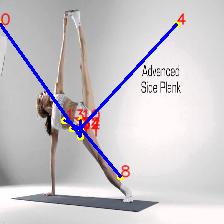

In [ ]:
BODY_PARTS = {"Head": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
              "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
              "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "Chest": 14,
              "Background": 15}

POSE_PAIRS = [["Head", "Neck"], ["Neck", "RShoulder"], ["RShoulder", "RElbow"],
              ["RElbow", "RWrist"], ["Neck", "LShoulder"], ["LShoulder", "LElbow"],
              ["LElbow", "LWrist"], ["Neck", "Chest"], ["Chest", "RHip"], ["RHip", "RKnee"],
              ["RKnee", "RAnkle"], ["Chest", "LHip"], ["LHip", "LKnee"], ["LKnee", "LAnkle"]]

# setting network
protoFile='/content/drive/MyDrive/인공지능팀플/pose_deploy_linevec_faster_4_stages.prototxt'
weightsFile='/content/drive/MyDrive/인공지능팀플/pose_iter_160000.caffemodel'
net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

image = cv2.imread('/content/drive/MyDrive/인공지능팀플/test data(openpose 안돌아가는 사진)/00000038.jpg')
image = cv2.resize(image, (224, 224))
imageHeight, imageWidth, imageColor = image.shape

#이미지 전처리
inpBlob = cv2.dnn.blobFromImage(image, 1.0 / 255, (imageWidth, imageHeight), (0, 0, 0), swapRB=False, crop=False)

net.setInput(inpBlob)

output=net.forward()

H = output.shape[2]
W = output.shape[3]


# points 이미지에 입력
points = []
for i in range(0, 15):
    probMap = output[0, i, :, :]


    #(9.076588321477175e-05, 0.27673089504241943, (17, 11), (10, 12))
    minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)

    # 원래 이미지에 맞게 점 위치 변경
    x = (imageWidth * point[0]) / W
    y = (imageHeight * point[1]) / H

    if prob > 0.001:
        cv2.circle(image, (int(x), int(y)), 3, (0, 255, 255), thickness=-1,
                   lineType=cv2.FILLED)  # circle(그릴곳, 원의 중심, 반지름, 색)
        cv2.putText(image, "{}".format(i), (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1,
                    lineType=cv2.LINE_AA)
        points.append((int(x), int(y)))
    else:
        points.append(None)

# 관절들 선으로 연결
for pair in POSE_PAIRS:
    partA = pair[0]  # Head
    partA = BODY_PARTS[partA]  # 0
    partB = pair[1]  # Neck
    partB = BODY_PARTS[partB]  # 1

    # print(partA," 와 ", partB, " 연결\n")
    if points[partA] and points[partB]:
        cv2.line(image, points[partA], points[partB], (255, 0, 0), 2)


cv2_imshow(image)
cv2.waitKey(0)
cv2.destroyAllWindows()

#Data set 가시화

In [ ]:
image_folder = '/content/drive/MyDrive/인공지능팀플/진짜DATA'
image_files = os.listdir(image_folder)
image_files.sort()

#image 순회하며 읽기
images = [] #list
for file_name in image_files:
    file_path = os.path.join(image_folder, file_name)
    image = cv2.imread(file_path)
    if image is not None:
        image = cv2.resize(image, (224, 224))
        images.append(image)

len(images)

3005

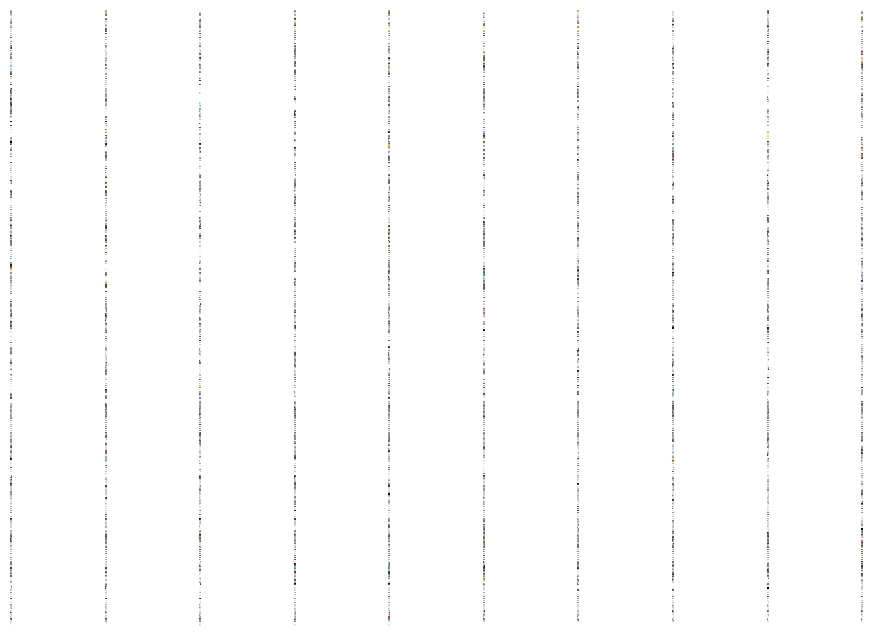

In [ ]:
#안돌려도 됨
plt.figure(figsize=(12, 8))
columns = 10
rows = (len(images) // columns) + 1

#이미지를 순회하면서 표시
for i, image in enumerate(images):
    plt.subplot(rows, columns, i + 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  #BGR을 RGB로 변환
    plt.axis('off')

plt.show()

#points_array 만드는 코드
너무 오래 걸려서 여러 번 돌리지 말 것

In [ ]:
#배열 생성 = (이미지, 15(관절), 2(x, y))
points_array = np.zeros((len(images), 15, 2))

#각 이미지에 대해 좌표 추출 및 저장
for i, image in enumerate(images):
    imageHeight, imageWidth, _ = image.shape
    inpBlob = cv2.dnn.blobFromImage(image, 1.0 / 255, (imageWidth, imageHeight), (0, 0, 0), swapRB=False, crop=False)

    net.setInput(inpBlob)
    output = net.forward()

    for j in range(0, 14):
        probMap = output[0, j, :, :]

        minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)
        #원래 이미지에 맞게 점 위치 변경
        x = (imageWidth * point[0]) / W
        y = (imageHeight * point[1]) / H

        points_array[i, j, 0] = x
        points_array[i, j, 1] = y

#하나하나 추출한 좌표값

In [ ]:
points_array.shape

(3005, 15, 2)

In [ ]:
coordinates =[
    [(130,30),(130,50),(120,50),(104,64),(104,88),(135,50),(145,80),(155,65),(112,96),(140,112),(136,152),(115,110),(115,140),(95,130),(120,80)],
    [(85, 170),(92, 155),(85, 135),(80, 160),(60, 190),(105, 155),(78, 180),(60, 205),(110,90),(110,20),(85, 65),(130, 100),(160, 150),(170, 180),(100, 130)],
    [(20, 110),(40, 110),(45,130),(50,165),(60,205),(42,80),(52,50),(60,20),(120,90),(170,100),(215, 90),(130, 100),(120, 150),(110, 205),(60, 115)],
    [(115, 70),(110, 75),(100,75),(105,60),(120,45),(120,80),(125,60),(125,45),(90,110),(90,80),(85,45),(100,120),(100,150),(100,180),(108, 85)],
    [(155, 105),(145, 120),(140,95),(135,65),(135,45),(155,150),(150,180),(155,210),(100,145),(80,70),(55,95),(100,125),(90,125),(40,115),(130, 130)],
    [(100, 50),(110, 65),(115,80),(145,90),(180,100),(120,60),(115,40),(90,20),(90,110),(40,105),(40,80),(110,120),(120,155),(115,195),(130, 70)],
    [(115, 65),(115, 85),(100,90),(85,85),(60,80),(125,83),(140,75),(165,65),(115,160),(160,155),(200,150),(100,160),(65,165),(35,165),(120, 100)],
    [(165, 115),(155, 105),(150,120),(155,175),(155,210),(155,75),(180,95),(195,130),(120,120),(85,170),(65,200),(110,95),(80,150),(55,200),(140,90)],
    [(125, 35),(125, 55),(110,70),(95,115),(70,105),(145,60),(165,60),(195,65),(125,180),(85,150),(35,105),(145,180),(185,185),(205,165),(115,85)],
    [(40, 35),(60, 75),(45,100),(65,150),(80,185),(75,55),(95,120),(90,185),(100,165),(130,185),(195,205),(125,120),(165,165),(200,195),(80,90)],
    [(180, 55),(160, 60),(145,50),(145,20),(180,10),(170,70),(165,95),(190,110),(105,90),(80,70),(70,100),(125,120),(125,155),(120,195),(145,70)],
    [(110, 35),(115, 55),(95,60),(65,50),(35,40),(145,60),(165,40),(195,35),(110,120),(115,155),(120,190),(135,110),(125,110),(110,110),(115,70)],
    [(105, 65),(100, 85),(90,85),(65,70),(45,60),(110,85),(130,55),(135,35),(100,160),(130,140),(165,120),(90,160),(70,175),(40,180),(105,100)],
    [(105, 135),(110, 120),(130,115),(130,145),(130,180),(90,115),(85,145),(80,180),(120,30),(160,45),(190,60),(100,30),(65,45),(30,65),(105,90)],
    [(105, 35),(100, 55),(75,45),(60,30),(80,20),(120,60),(155,65),(145,45),(80,115),(90,160),(105,190),(115,115),(110,160),(160,135),(95,75)],
    [(100, 55),(120, 65),(90,70),(60,75),(60,45),(140,50),(150,35),(120,20),(150,115),(180,140),(130,145),(140,115),(160,150),(135,185),(135,75)],
    [(100, 45), (95, 50), (70,70), (40,50), (20,20), (120,75), (150,90), (180,87), (70,115), (100,170), (110,200), (95,115), (30,140), (95,145), (85,75)],
    [(160, 65),(150, 85), (120,75), (75,80),(75,95), (170,100),(175,130),(170,160),  (50,100),(50,65),(60,25),(75,130),(75,165),(90,200),(130,100)],
    [(110, 85), (110, 100),(90,105), (70,105), (50,100), (130,105), (145,110), (170,110), (95,145), (60,140), (30,130), (115,145), (145,140), (170,140), (110,120)],
    [(90, 70),(90, 90),(70,105), (50,100), (25,105), (100,80), (130,65), (150,40), (70,155), (50,170), (25,195), (95,145), (135,150), (170,150), (90,105)],
    [(96, 40),  (96, 60),(80,58), (70,70), (60,80), (115,60), (145,60), (130,40), (80,105), (120,90), (160,100), (100,110), (105,140), (95,170), (100,70)],
    [(100, 45),(100, 60),(95,60), (80,80),(70,90),(110,60),(120,50),(130,30),(95,105),(95,150),(70,130),(100,110),(105,150),(110,185),(105,70)],
    [(130, 20),(130, 45),(125,45),(105,55),(80,55),(145,50),(150,80),(145,100),(125,100), (100,90),(75,80),(135,100),(130,150),(125,195),(130,65)],
    [(135, 20),(140, 45),(125,45),(95,55),(75,60),(150,45),(160,20),(145,10),(125,100),(85,100),(50,110),(140,110),(130,150),(125,195),(150,65)],
    [(104, 25),(104, 45),(90,60),(75,50),(40,30),(120,50),(140,40),(165,30),(125,100),(115,140),(105,160),(130,80),(155,75),(190,65),(104,70)],
    [(104, 10), (104, 35), (90,30), (70,50), (75,30), (115,30), (125,60),(104,65), (90,100), (90,145),(85,180),(110,95),(125,125),(115,155),(104,50)],
    [(110, 50),(105, 60),(92,60),(88,48),(88,32),(112,64),(140,64),(160,48),(120,110),(145,115),(165,100),(120,104),(72,112),(110,130),(100,80)],
    [(110, 30),(110, 50),(95,50),(85,60),(70,70),(125,50),(140,50),(150,30),(100,110),(97,150),(85,110),(120,110),(130,130),(150,170),(110,80)],
    [(80, 50),(80,65),(60,65),(45,40),(40,20),(95,80),(130,85),(170,85),(100,115),(125,145),(170,120),(95,120),(95,160),(85,190),(75,85)],
    [(80, 30),(80,50),(72,56),(60,50),(60,32),(88,56),(112,48),(125,32),(72,112),(80,153),(100,140),(88,104),(88,160),(88,200),(80,80)],
    [(50, 110),(65, 118),(60,135),(62,170),(63,195),(70,100),(80,70),(95,30),(100,160),(130,175),(160,200),(110,140),(110,90),(110,40),(75,125)],
    [(75, 110),(85, 118),(84,135),(81,170),(81,195),(88,95),(97,60),(103,30),(130,150),(158,176),(180,200),(125,125),(120,80),(120,30),(100,120)],
    [(82, 72),(90, 85),(95,70),(110,55),(130,25),(90,100),(95,125),(105,165),(130,80),(152,62),(170,50),(125,110),(120,160),(118,190),(100,90)],
    [(120, 20),(120,48),(96,48),(72,48),(64,32),(136,48),(168,48),(192,40),(88,96),(65,60),(39,42),(104,104),(96,144),(88,184),(112,72)],
    [(150, 70),(128,88),(112,80),(112,48),(96,32),(144,104),(152,128),(168,152),(55,100),(16,64),(54,38),(64,110),(48,152),(40,192),(110,105)],
    [(162, 50),(152, 64),(128, 64),(104, 88),(130, 80),(168, 80),(152, 104),(152, 88),(96, 96),(73, 64),(45, 30),(112, 112),(112, 152),(120, 192),(135, 88)],
    [(64, 55),(64, 80),(48, 80),(40, 48),(56, 32),(72, 72),(80, 56),(72, 32),(72, 120),(88, 152),(88, 192),(88, 112),(140, 112),(180, 105),(72, 96)],
    [(152, 60),(136, 80),(120, 72),(120, 40),(128, 24),(144, 88),(144, 120),(160, 112),(88, 112),(88, 70),(88, 40),(104, 120),(96, 160),(98, 200),(112, 96)],
    [(120, 60),(128, 70),(150, 85),(175, 95),(200, 100),(120, 80),(110, 70),(100, 60),(115, 120),(115, 152),(115, 192),(100, 110),(70, 90),(30, 75),(135, 90)],
    [(130, 52),(140, 72),(120, 80),(120, 96),(152, 96),(160, 72),(176, 96),(200, 80),(125, 115),(80, 90),(40, 70),(144, 120),(136, 160),(136, 200),(140, 96)],
    [(100, 40),(100, 75),(85, 80),(65, 90),(45, 95),(110, 75),(130, 65),(145, 50),(90, 170),(65, 150),(30, 100),(110, 170),(160, 190),(200, 160),(95, 100)],
    [(128, 108),(126, 123),(110, 118),(95, 107),(73, 98),(128, 132),(150, 139),(175, 145),(80, 135),(65, 102),(55, 80),(70, 140),(72, 170),(75, 200),(115, 140)],
    [(90, 60),(96, 80),(72, 88),(64, 64),(56, 32),(112, 80),(148, 96),(128, 96),(100, 128),(104, 168),(112, 200),(118, 120),(135, 90),(170, 50),(96, 104)],
    [(185, 60),(185, 80),(170, 74),(140, 80),(165, 90),(205, 88),(202, 100),(185, 99),(144, 110),(96, 92),(56, 64),(152, 115),(150, 150),(155, 190),(170, 96)],
    [(90, 70),(110, 70),(123, 70),(103, 50),(78, 60),(133, 65),(150, 45),(175, 23),(120, 110),(78, 120),(65, 90),(130, 120),(120, 160),(100, 190),(112, 96)],
    [(55, 105),(72, 112),(72, 128),(64, 152),(50, 168),(90, 100),(95, 85),(100, 70),(130, 128),(140, 152),(133, 170),(130, 110),(145, 90),(165, 60),(96, 112)],
    [(200, 136),(168, 136),(160, 120),(150, 90),(140, 70),(152, 144),(160, 168),(168, 200),(80, 104),(60, 60),(125, 55),(80, 115),(80, 160),(80, 200),(130, 135)],
    [(75, 170),(75, 150),(90, 145),(92, 177),(90, 200),(60, 145),(55, 177),(50, 200),(85, 85),(115, 70),(140, 65),(70, 85),(40, 75),(60, 50),(75, 120)],
    [(112, 35),(104, 56),(88, 56),(64, 72),(50, 65),(120, 56),(144, 48),(144, 24),(90, 104),(54, 95),(30, 85),(107, 104),(150, 104),(190, 90),(112, 80)],
    [(96, 35),(88, 64),(64, 72),(40, 64),(24, 40),(112, 72),(144, 72),(180, 73),(70, 120),(42, 75),(32, 45),(85, 125),(72, 168),(64, 208),(90, 100)],
    [(112.0, 24.0),(104.0, 56.0),(88.0, 64.0),(72.0, 48.0),(48.0, 24.0),(120.0, 64.0),(152.0, 72.0),(176.0, 72.0),(118.0, 115.0),(160.0, 105.0),(184.0, 88.0),(105.0, 120.0),(88.0, 160.0),(56.0, 184.0),(112.0, 88.0)],
    [(56.0, 32.0),(72.0, 56.0),(56.0, 56.0),(24.0, 40.0),(16.0, 16.0),(96.0, 56.0),(120.0, 80.0),(152.0, 80.0),(96.0, 112.0),(104.0, 152.0),(120.0, 192.0),(112.0, 96.0),(152.0, 80.0),(184.0, 56.0),(88.0, 80.0)],
    [(120.0, 40.0),(128.0, 64.0),(145.0, 64.0),(160.0, 50.0),(186, 20),(115.0, 64.0),(90.0, 60.0),(40.0, 48.0),(130,112), (88.0, 160.0),(104.0, 200.0),(112.0, 112.0),(70.0, 80.0),(45.0, 60.0),(120.0, 88.0)],
    [(56.0, 56.0),(96.0, 64.0),(88.0 ,80.0),(50.0, 72.0),(20, 55.0),(112.0, 56.0),(152.0, 48.0),(176.0, 32.0),(120.0, 104.0),(128, 152),(112.0, 200.0),(140.0, 104.0),(155.0, 65.0),(157, 35.0),(112.0, 88.0)],
    [(184.0, 40.0),(144.0, 40.0),(138.0, 42.0),(90.0, 45.0),(42.0, 40.0),(136.0, 55.0),(100.0, 50.0),(65.0, 35.0),(140.0, 120.0),(110.0, 150.0),(120.0, 200.0),(150.0, 120.0),(80.0, 80.0),(40.0, 50.0),(130.0, 80.0)],
    [(64.0, 50.0),(64.0, 72.0),(48.0, 80.0),(88.0, 48.0),(112.0, 16.0),(64.0, 80.0),(72.0, 32.0),(118.0, 30.0),(112.0, 112.0),(112.0, 160.0),(120.0, 208.0),(120.0, 96.0),(176.0, 64.0),(160.0, 30.0),(80.0, 96.0)],
    [(100.0,65.0),(104.0, 80.0),(88.0, 80.0),(72.0, 80.0),(48.0, 80.0),(113.0, 75.0),(130.0, 53.0),(140.0, 40.0),(112.0, 120.0),(140.0, 70.0),(160.0, 40.0),(128.0, 112.0),(120.0, 152.0),(120.0, 184.0),(112.0, 96.0)],
    [(136.0, 40.0),(128.0, 64.0),(112.0, 64.0),(88.0, 64.0),(72.0, 56.0),(144.0, 72.0),(176.0, 56.0),(192.0, 48.0),(88.0, 96.0),(64.0, 64.0),(35.0, 40.0),(107.0, 118.0),(88.0, 152.0),(80.0, 192.0),(130.0, 88.0)],
    [(136.0, 60.0),(152.0, 64.0),(136.0, 64.0),(100.0, 40.0),(70.0, 24.0),(168.0, 64.0),(135.0, 38.0),(104.0, 24.0),(125.0, 110.0),(88.0, 152.0),(112.0, 192.0),(112.0, 112.0),(80.0, 70.0),(112.0, 192.0),(136.0, 88.0)],
    [(168.0, 40.0),(144.0, 72.0),(120.0, 64.0),(80.0, 48.0),(40.0, 24.0),(160.0, 88.0),(168.0, 112.0),(200.0, 120.0),(64.0, 80.0),(80.0, 144.0),(22.0, 30.0),(64.0, 65.0), (22.0, 60.0),(72.0, 192.0),(104.0, 80.0)],
    [(88.0, 48.0),(80.0, 80.0),(72.0 ,88.0),(64.0, 48.0),(96.0, 24.0),(88.0, 80.0),(96.0, 48.0),(104.0, 24.0),(130.0, 90.0),(135.0, 65.0),(128.0, 30.0),(136.0, 104.0),(120.0, 152.0),(128.0, 192.0),(104.0, 96.0)],
    [(72.0, 72.0),(112.0, 80.0),(120.0, 64.0),(104.0, 48.0),(65.0, 65.0),(128.0, 64.0),(160.0, 45.0),(175,30),(120.0, 110.0),(60.0, 130.0),(55.0, 100.0),(110.0, 110.0),(120.0, 170.0),(96.0, 200.0),(140.0, 80.0)],
    [(136.0, 40.0),(128.0, 64.0),(144.0, 80.0),(168.0, 96.0),(192.0, 104.0),(104.0, 64.0),(80.0, 64.0),(16.0, 40.0),(98.0, 104.0),(88.0, 152.0),(88.0, 190.0),(72.0, 88.0),(40.0, 64.0),(16.0, 40.0),(120.0, 80.0)],
    [(152.0, 30.0),(136.0, 48.0),(120.0, 48.0),(110.0, 45.0),(100.0, 45.0),(152.0, 72.0),(168.0, 88.0),(184.0, 96.0),(88.0, 88.0),(65.0, 50.0),(70.0, 20),(104.0, 104.0),(80.0, 152.0),(64.0, 200.0),(112.0, 80.0)],
    [(24.0, 56.0),(64.0, 64.0),(80.0, 72.0),(105.0, 56.0),(128.0, 32.0),(95.0, 60.0),(128.0, 56.0),(160.0, 48.0),(120.0, 112.0),(128.0, 168.0),(112.0, 208.0),(128.0, 96.0),(159.0, 70.0),(175.0, 40.0),(96.0, 88.0)],
    [(144.0, 20.0),(160.0, 48.0),(128.0, 48.0),(88.0 ,40.0),(48.0, 32.0),(176.0, 48.0),(208.0, 72.0),(176.0, 64.0),(95.0, 85.0),(35.0, 85.0),(24.0, 48.0),(100.0, 104.0),(112.0, 152.0),(96.0, 208.0),(160.0, 80.0)],
    [(152.0, 56.0),(136.0, 88.0),(120.0, 72.0),(120.0, 40.0),(104.0, 24.0),(152.0, 104.0),(160.0, 128.0),(176.0, 160.0),(72.0, 104.0),(15.0, 55.0),(64.0, 32.0),(72.0, 120.0),(56.0, 152.0),(48.0, 200.0),(120.0, 96.0)],
    [(55.0, 72.0),(88.0, 72.0),(96.0, 80.0),(64.0, 88.0),(48.0, 88.0),(112.0, 50.0),(144.0, 32.0),(168.0, 16.0),(144.0, 96.0),(96.0, 152.0),(48.0, 128.0),(162.0, 96.0),(128.0, 160.0),(104.0, 200.0),(128.0, 80.0)],
    [(16.0, 56.0),(40.0, 80.0),(32.0, 96.0),(64.0, 56.0),(80.0, 32.0),(32.0, 96.0),(64.0, 120.0),(88.0, 136.0),(104.0, 120.0), (72.0, 152.0),(72.0, 200.0),(96.0, 90.0),(152.0, 65.0),(190.0, 45.0),(64.0, 96.0)],
    [(176.0, 56.0),(152.0, 80.0),(136.0, 72.0),(120.0, 56.0),(96.0, 32.0),(160.0, 88.0),(176.0, 104.0),(192.0, 96.0),(88.0, 80.0),(56.0, 56.0),(30, 20),(104.0, 104.0),(112.0, 144.0),(120.0, 192.0),(128.0, 88.0)],
    [(128, 32), (128, 56), (112, 56), (88, 48), (72, 32), (136, 64), (144, 88), (136, 72), (96, 75), (96, 128), (88, 168), (112, 96), (62, 60), (54, 40), (112, 72)],
    [(120, 48), (104, 72), (88, 64), (56, 48), (40, 32), (128, 72), (152, 72), (176, 72), (74, 94), (50, 70), (30, 48), (95, 112), (64, 144), (48, 176), (96, 88)],
    [(168, 88), (144, 104), (128, 96), (96, 88), (72, 72), (152, 120), (152, 136), (160, 152), (88, 112), (48, 94), (32, 70), (104, 128), (96, 160), (80, 192), (120, 120)],
    [(72, 60), (88, 80), (98, 68), (110, 54), (128, 32), (88, 96), (96, 128), (104, 160), (118, 80), (150, 64), (168, 44), (114, 110), (112, 144), (112, 184), (104, 96)],
    [(152, 32), (120, 48), (130, 56), (176, 40), (176, 56), (96, 48), (48, 40), (16, 24), (94, 104), (112, 152), (128, 192), (138, 86), (184, 104), (184, 88), (112, 72)],
    [(144, 32), (136, 56), (112, 48), (88, 40), (72, 24), (144, 72), (136, 96), (136, 112), (88, 80), (50, 58), (36, 42), (104, 104), (96, 144), (80, 184), (112, 80)],
    [(104, 10), (114, 44), (88, 40), (64, 48), (32, 40), (128, 40), (144, 56), (168, 72), (88, 96), (112, 128), (120, 176), (120, 96), (152, 112), (184, 128), (104, 72)],
    [(168, 88), (136, 80), (136, 72), (128, 48), (108, 40), (128, 80), (106, 60), (98, 40), (110, 104), (126, 126), (180, 126), (88, 104), (104, 144), (128, 176), (112, 88)],
    [(88, 32), (80, 56), (56, 64), (64, 24), (96, 16), (96, 56), (120, 48), (155, 24), (86, 112), (112, 152), (112, 184), (112, 94), (136, 56), (136, 24), (88, 80)],
    [(150, 70), (150, 84), (140, 84), (140, 64), (142, 44), (158, 84), (154, 64), (146, 44), (120, 104), (104, 64), (118, 40), (126, 130), (120, 150), (120, 180), (148, 104)],
    [(80, 40), (80, 64), (56, 72), (64, 32), (88, 24), (96, 72), (120,48), (140, 32), (76, 112), (112, 160), (120, 184),(104, 96), (128, 76), (120, 34),(88,88)],
    [(88, 26), (84, 40), (64, 48), (40, 54), (16, 56), (98, 40), (114, 38), (136, 32), (64, 88), (96, 104), (128, 128), (104, 80), (144, 96), (178, 100), (90, 64)],
    [(144, 40), (140, 64), (120, 64), (96, 40), (80, 24), (152, 80), (176, 104), (200, 128), (88, 90), (16, 76), (44, 30), (100, 120), (88, 152), (96, 192), (130, 88)],
    [(92, 46), (88, 72), (76, 78), (72, 44), (72, 16), (110, 80), (120, 48), (140, 32), (138, 84), (160, 60), (160, 32), (140, 122), (144, 144), (152, 184), (80, 100)],
    [(136, 38), (136, 64), (120, 64), (88, 50), (60, 30), (144, 72), (168, 76), (184, 64), (50, 110), (48, 64), (48, 30), (108, 112), (56, 140), (56, 184), (104, 80)],
    [(64, 78), (88, 80), (94, 90), (124, 98), (88, 94), (104, 66), (128, 40), (114, 28), (112, 120), (100, 148), (80, 112), (120, 112), (120, 148), (102, 184), (120, 80)],
    [(24, 44), (64, 44), (64, 62), (70, 74), (24, 88), (90, 18), (148, 24), (194, 24), (90, 88), (88, 136), (40, 114), (124, 88), (114, 136), (72, 184), (88, 40)],
    [(120, 48), (120, 70), (130, 58), (122, 36), (112, 26), (110, 60), (92, 64), (92, 46), (120, 104), (116, 144), (110, 200), (110, 88), (76, 68), (82, 34), (130, 70)],
    [(110, 80), (110, 90), (104, 90), (106, 70), (114, 56), (118, 90), (120, 70), (125, 56), (120, 104), (126, 80), (128, 56), (120, 122), (124, 144), (122, 184), (108, 100)],
    [(96, 60), (88, 72), (72, 72), (88, 40), (120, 24), (98, 72), (108, 60), (128, 32), (122, 88), (138, 60), (112, 184), (122, 126), (112, 144), (138, 34), (72, 96)],

]

coordinates=np.array(coordinates)

In [ ]:
print(coordinates.shape)
points_array = np.concatenate((points_array, coordinates), axis=0)
print(points_array.shape)

(90, 15, 2)
(3095, 15, 2)


"Head": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4, "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9, "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "Chest": 14

In [ ]:
head_points=points_array[:,0]
neck_points=points_array[:,1]
Rshoulder_points=points_array[:,2]
Relbow_points=points_array[:,3]
Rwrist_points=points_array[:,4]
Lshoulder_points=points_array[:,5]
Lelbow_points=points_array[:,6]
Lwrist_points=points_array[:,7]
Rhip_points=points_array[:,8]
Rknee_points=points_array[:,9]
Rankle_points=points_array[:,10]
Lhip_points=points_array[:,11]
Lknee_points=points_array[:,12]
Lankle_points=points_array[:,13]
chest_points=points_array[:,14]


print(head_points.shape, neck_points.shape, Rshoulder_points.shape,
      Relbow_points.shape, Rwrist_points.shape, Lshoulder_points.shape,
      Lelbow_points.shape, Lwrist_points.shape, Rhip_points.shape,
      Rankle_points.shape, Lhip_points.shape, Lknee_points.shape,
      Lankle_points.shape, chest_points.shape)

(3095, 2) (3095, 2) (3095, 2) (3095, 2) (3095, 2) (3095, 2) (3095, 2) (3095, 2) (3095, 2) (3095, 2) (3095, 2) (3095, 2) (3095, 2) (3095, 2)


In [ ]:
#안돌려도 됨

for i, points in enumerate(points_array):
    print(f"image {i+1}:")
    for j, (x, y) in enumerate(points):
        print(f"point {j+1}: x={x}, y={y}")

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
point 8: x=184.0, y=104.0
point 9: x=112.0, y=104.0
point 10: x=112.0, y=144.0
point 11: x=104.0, y=184.0
point 12: x=144.0, y=104.0
point 13: x=152.0, y=144.0
point 14: x=152.0, y=192.0
point 15: x=0.0, y=0.0
image 2784:
point 1: x=112.0, y=16.0
point 2: x=112.0, y=48.0
point 3: x=88.0, y=56.0
point 4: x=64.0, y=56.0
point 5: x=40.0, y=56.0
point 6: x=128.0, y=56.0
point 7: x=160.0, y=56.0
point 8: x=192.0, y=56.0
point 9: x=104.0, y=112.0
point 10: x=88.0, y=160.0
point 11: x=80.0, y=192.0
point 12: x=120.0, y=112.0
point 13: x=136.0, y=160.0
point 14: x=144.0, y=192.0
point 15: x=0.0, y=0.0
image 2785:
point 1: x=104.0, y=8.0
point 2: x=96.0, y=40.0
point 3: x=72.0, y=48.0
point 4: x=32.0, y=64.0
point 5: x=64.0, y=80.0
point 6: x=120.0, y=40.0
point 7: x=160.0, y=64.0
point 8: x=136.0, y=64.0
point 9: x=88.0, y=104.0
point 10: x=88.0, y=144.0
point 11: x=96.0, y=176.0
point 12: x=120.0, y=104.0
point 13: x=144.0, y=136.0
point 14: x=144.0, y=184.

# DenseNet

이거 돌리는데 개오래걸림

In [ ]:
from keras.applications import DenseNet121
from keras.applications.densenet import preprocess_input

densenet_model = DenseNet121(weights='imagenet', include_top=False)
preprocessed_images = preprocess_input(np.array(images))
features = densenet_model.predict(preprocessed_images)

data_features = []
for image_file in image_files:
    image_path = os.path.join(image_folder, image_file)
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))
    img = preprocess_input(img)
    img = np.expand_dims(img, axis=0)
    feature = densenet_model.predict(img)
    data_features.append(feature)

data_features = np.concatenate(data_features, axis=0)

#저장
np.save('data_features.npy', features)
print(data_features.shape)

1/1 [==============================] - 0s 28ms/step
(3005, 7, 7, 1024)


In [ ]:
#다리올 feature
dariup_folder_path = '/content/drive/MyDrive/인공지능팀플/다리올'
dariup_image_files = sorted([file for file in os.listdir(dariup_folder_path) if file.lower().endswith(('.jpg', '.jpeg', '.png'))])

dariup_features = np.zeros((len(dariup_image_files), 7, 7, 1024))

#특징 벡터 추출
for i, image_file in enumerate(dariup_image_files):
    img_path = os.path.join(dariup_folder_path, image_file)
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    dariup_features[i] = densenet_model.predict(image)

#저장
save_path = 'dariup_features.npy'
np.save(save_path, dariup_features)

#불러오기
dariup_features = np.load(save_path)
print(dariup_features.shape)

1/1 [==============================] - 0s 30ms/step
(90, 7, 7, 1024)


In [ ]:
#두 feature값 merge

final_features = np.concatenate((data_features, dariup_features), axis=0)
print(final_features.shape)
print(data_features.shape)
print(dariup_features.shape)

(3095, 7, 7, 1024)
(3005, 7, 7, 1024)
(90, 7, 7, 1024)


#예측할 사진의 feature 뽑아내기

In [ ]:
img_path = '/content/drive/MyDrive/KakaoTalk_20230603_205127037.jpg'

img_pil = Image.open(img_path).resize((224, 224))
img = np.array(img_pil)
x = np.expand_dims(img, axis=0)
x = preprocess_input(x)
features1 = densenet_model.predict(x)
print(features1.shape)

1/1 [==============================] - 0s 32ms/step
(1, 7, 7, 1024)


#좌표별 train, val

In [ ]:
from sklearn.model_selection import train_test_split
train_ratio = 0.8

#head
head_train_images, head_validation_images, head_train_coords, head_validation_coords = train_test_split(
    final_features, head_points, test_size=1 - train_ratio, shuffle=True, random_state=42
)

#neck
neck_train_images, neck_validation_images, neck_train_coords, neck_validation_coords = train_test_split(
    final_features, neck_points, test_size=1 - train_ratio, shuffle=True, random_state=42
)

#Rshoulder
Rshoulder_train_images, Rshoulder_validation_images, Rshoulder_train_coords, Rshoulder_validation_coords = train_test_split(
    final_features, Rshoulder_points, test_size=1 - train_ratio, shuffle=True, random_state=42
)

#Relbow
Relbow_train_images, Relbow_validation_images, Relbow_train_coords, Relbow_validation_coords = train_test_split(
    final_features, Relbow_points, test_size=1 - train_ratio, shuffle=True, random_state=42
)

#Rwrist
Rwrist_train_images, Rwrist_validation_images, Rwrist_train_coords, Rwrist_validation_coords = train_test_split(
    final_features, Rwrist_points, test_size=1 - train_ratio, shuffle=True, random_state=42
)

#Lshoulder
Lshoulder_train_images, Lshoulder_validation_images, Lshoulder_train_coords, Lshoulder_validation_coords = train_test_split(
    final_features, Lshoulder_points, test_size=1 - train_ratio, shuffle=True, random_state=42
)

#Lelbow
Lelbow_train_images, Lelbow_validation_images, Lelbow_train_coords, Lelbow_validation_coords = train_test_split(
    final_features, Lelbow_points, test_size=1 - train_ratio, shuffle=True, random_state=42
)

#Lwrist
Lwrist_train_images, Lwrist_validation_images, Lwrist_train_coords, Lwrist_validation_coords = train_test_split(
    final_features, Lwrist_points, test_size=1 - train_ratio, shuffle=True, random_state=42
)

#Rhip
Rhip_train_images, Rhip_validation_images, Rhip_train_coords, Rhip_validation_coords = train_test_split(
    final_features, Rhip_points, test_size=1 - train_ratio, shuffle=True, random_state=42
)

#Rknee
Rknee_train_images, Rknee_validation_images, Rknee_train_coords, Rknee_validation_coords = train_test_split(
    final_features, Rknee_points, test_size=1 - train_ratio, shuffle=True, random_state=42
)

#Rankle
Rankle_train_images, Rankle_validation_images, Rankle_train_coords, Rankle_validation_coords = train_test_split(
    final_features, Rankle_points, test_size=1 - train_ratio, shuffle=True, random_state=42
)

#Lhip
Lhip_train_images, Lhip_validation_images, Lhip_train_coords, Lhip_validation_coords = train_test_split(
    final_features, Lhip_points, test_size=1 - train_ratio, shuffle=True, random_state=42
)

#Lknee
Lknee_train_images, Lknee_validation_images, Lknee_train_coords, Lknee_validation_coords = train_test_split(
    final_features, Lknee_points, test_size=1 - train_ratio, shuffle=True, random_state=42
)

#Lankle
Lankle_train_images, Lankle_validation_images, Lankle_train_coords, Lankle_validation_coords = train_test_split(
    final_features, Lankle_points, test_size=1 - train_ratio, shuffle=True, random_state=42
)

#chest
chest_train_images, chest_validation_images, chest_train_coords, chest_validation_coords = train_test_split(
    final_features, chest_points, test_size=1 - train_ratio, shuffle=True, random_state=42
)

print(neck_train_coords.shape)
print(neck_validation_coords.shape)

(2476, 2)
(619, 2)


# *CNN*

In [ ]:
from keras.layers import Dropout

filter_size = 3
pool_size = 1


#관절마다 CNN

In [ ]:
head_CNN = Sequential([
  keras.Input(shape=(7,7,1024)),

  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  MaxPooling2D(pool_size=pool_size), Dropout(0.25),

  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  MaxPooling2D(pool_size=pool_size), Dropout(0.25),

  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  MaxPooling2D(pool_size=pool_size),

  Flatten(), Dense(50), Activation('relu'), Dense(10), Activation('relu'), Dense(2),

])


head_checkpoint_filepath = "/content/drive/MyDrive/김동하/checkpoint/head_best.ckpt"
head_model_checkpoint_callback = ModelCheckpoint(
    filepath=head_checkpoint_filepath, save_weights_only=True, monitor='val_accuracy', mode='min', save_best_only=True, verbose=1)


head_CNN.compile('adam', loss='mse', metrics=['accuracy'],)

head_CNN.fit(head_train_images, head_train_coords, validation_data=(head_validation_images, head_validation_coords), epochs=50, batch_size=128
             ,callbacks=[head_model_checkpoint_callback])

Epoch 1/50
18/20 [==========================>...] - ETA: 0s - loss: 3642.1221 - accuracy: 0.9149
Epoch 1: val_accuracy improved from inf to 0.94669, saving model to /content/drive/MyDrive/김동하/checkpoint/head_best.ckpt
20/20 [==============================] - 6s 54ms/step - loss: 3454.9446 - accuracy: 0.9164 - val_loss: 1446.5109 - val_accuracy: 0.9467
Epoch 2/50
19/20 [===========================>..] - ETA: 0s - loss: 553.7545 - accuracy: 0.9494
Epoch 2: val_accuracy did not improve from 0.94669
20/20 [==============================] - 0s 21ms/step - loss: 554.2189 - accuracy: 0.9487 - val_loss: 2233.3860 - val_accuracy: 0.9467
Epoch 3/50
19/20 [===========================>..] - ETA: 0s - loss: 432.5906 - accuracy: 0.9486
Epoch 3: val_accuracy did not improve from 0.94669
20/20 [==============================] - 0s 21ms/step - loss: 432.5131 - accuracy: 0.9487 - val_loss: 686.4622 - val_accuracy: 0.9467
Epoch 4/50
17/20 [========================>.....] - ETA: 0s - loss: 316.8846 - accu

neck

In [ ]:
neck_CNN = Sequential([
  keras.Input(shape=(7,7,1024)),

  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  MaxPooling2D(pool_size=pool_size), Dropout(0.25),

  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  MaxPooling2D(pool_size=pool_size), Dropout(0.25),

  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  MaxPooling2D(pool_size=pool_size),

  Flatten(), Dense(50), Activation('relu'), Dense(10), Activation('relu'), Dense(2),

])

neck_checkpoint_filepath = "/content/drive/MyDrive/김동하/checkpoint/neck_best.ckpt"
neck_model_checkpoint_callback = ModelCheckpoint(
    filepath=neck_checkpoint_filepath, save_weights_only=True, monitor='val_accuracy', mode='min', save_best_only=True, verbose=1)


neck_CNN.compile('adam', loss='mse', metrics=['accuracy'],)

neck_CNN.fit(neck_train_images, neck_train_coords, validation_data=(neck_validation_images, neck_validation_coords),  epochs=50, batch_size=128
             ,callbacks=[neck_model_checkpoint_callback])

Epoch 1/50
20/20 [==============================] - ETA: 0s - loss: 4958.5342 - accuracy: 0.1918
Epoch 1: val_accuracy improved from inf to 0.04200, saving model to /content/drive/MyDrive/김동하/checkpoint/neck_best.ckpt
20/20 [==============================] - 6s 50ms/step - loss: 4958.5342 - accuracy: 0.1918 - val_loss: 1755.9299 - val_accuracy: 0.0420
Epoch 2/50
17/20 [========================>.....] - ETA: 0s - loss: 1121.2549 - accuracy: 0.3635
Epoch 2: val_accuracy did not improve from 0.04200
20/20 [==============================] - 0s 21ms/step - loss: 1063.0521 - accuracy: 0.4342 - val_loss: 562.6754 - val_accuracy: 0.9580
Epoch 3/50
19/20 [===========================>..] - ETA: 0s - loss: 364.4797 - accuracy: 0.9420
Epoch 3: val_accuracy did not improve from 0.04200
20/20 [==============================] - 0s 20ms/step - loss: 362.0462 - accuracy: 0.9426 - val_loss: 461.2443 - val_accuracy: 0.9580
Epoch 4/50
18/20 [==========================>...] - ETA: 0s - loss: 271.4142 - acc

Rshoulder

In [ ]:
Rshoulder_CNN = Sequential([
  keras.Input(shape=(7,7,1024)),

  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  MaxPooling2D(pool_size=pool_size), Dropout(0.25),

  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  MaxPooling2D(pool_size=pool_size), Dropout(0.25),

  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  MaxPooling2D(pool_size=pool_size),

  Flatten(), Dense(50), Activation('relu'), Dense(10), Activation('relu'), Dense(2),

])

Rshoulder_checkpoint_filepath = "/content/drive/MyDrive/김동하/checkpoint/Rshoulder_best.ckpt"
Rshoulder_model_checkpoint_callback = ModelCheckpoint(
    filepath=Rshoulder_checkpoint_filepath, save_weights_only=True, monitor='val_accuracy', mode='min', save_best_only=True, verbose=1)


Rshoulder_CNN.compile('adam', loss='mse', metrics=['accuracy'],)

Rshoulder_CNN.fit(Rshoulder_train_images, Rshoulder_train_coords, validation_data=(Rshoulder_validation_images, Rshoulder_validation_coords),  epochs=50, batch_size=128
             ,callbacks=[Rshoulder_model_checkpoint_callback])

Epoch 1/50
17/20 [========================>.....] - ETA: 0s - loss: 3558.1348 - accuracy: 0.2872
Epoch 1: val_accuracy improved from inf to 0.10501, saving model to /content/drive/MyDrive/김동하/checkpoint/Rshoulder_best.ckpt
20/20 [==============================] - 6s 53ms/step - loss: 3216.1331 - accuracy: 0.2662 - val_loss: 700.1867 - val_accuracy: 0.1050
Epoch 2/50
20/20 [==============================] - ETA: 0s - loss: 430.8440 - accuracy: 0.8489
Epoch 2: val_accuracy did not improve from 0.10501
20/20 [==============================] - 0s 20ms/step - loss: 430.8440 - accuracy: 0.8489 - val_loss: 502.1688 - val_accuracy: 0.8966
Epoch 3/50
20/20 [==============================] - ETA: 0s - loss: 257.7301 - accuracy: 0.8990
Epoch 3: val_accuracy did not improve from 0.10501
20/20 [==============================] - 0s 20ms/step - loss: 257.7301 - accuracy: 0.8990 - val_loss: 465.0693 - val_accuracy: 0.9079
Epoch 4/50
18/20 [==========================>...] - ETA: 0s - loss: 160.6200 - a

Relbow

In [ ]:
Relbow_CNN = Sequential([
  keras.Input(shape=(7,7,1024)),

  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  MaxPooling2D(pool_size=pool_size),

  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  MaxPooling2D(pool_size=pool_size),

  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  MaxPooling2D(pool_size=pool_size),

  Flatten(), Dense(50), Activation('relu'), Dense(10), Activation('relu'), Dense(2),

])

Relbow_checkpoint_filepath = "/content/drive/MyDrive/김동하/checkpoint/Relbow_best.ckpt"
Relbow_model_checkpoint_callback = ModelCheckpoint(
    filepath=Relbow_checkpoint_filepath, save_weights_only=True, monitor='val_accuracy', mode='min', save_best_only=True, verbose=1)


Relbow_CNN.compile('adam', loss='mse', metrics=['accuracy'],)

Relbow_CNN.fit(Relbow_train_images, Relbow_train_coords, validation_data=(Relbow_validation_images, Relbow_validation_coords),  epochs=70, batch_size=256
             ,callbacks=[Relbow_model_checkpoint_callback])

Epoch 1/70
10/10 [==============================] - ETA: 0s - loss: 5298.0171 - accuracy: 0.5699
Epoch 1: val_accuracy improved from inf to 0.60743, saving model to /content/drive/MyDrive/김동하/checkpoint/Relbow_best.ckpt
10/10 [==============================] - 6s 115ms/step - loss: 5298.0171 - accuracy: 0.5699 - val_loss: 4241.9678 - val_accuracy: 0.6074
Epoch 2/70
 9/10 [==========================>...] - ETA: 0s - loss: 1915.9197 - accuracy: 0.6024
Epoch 2: val_accuracy did not improve from 0.60743
10/10 [==============================] - 0s 37ms/step - loss: 1843.2524 - accuracy: 0.6022 - val_loss: 2326.8999 - val_accuracy: 0.6074
Epoch 3/70
 8/10 [=======================>......] - ETA: 0s - loss: 694.2659 - accuracy: 0.6035
Epoch 3: val_accuracy did not improve from 0.60743
10/10 [==============================] - 0s 36ms/step - loss: 689.3949 - accuracy: 0.6042 - val_loss: 828.1173 - val_accuracy: 0.6074
Epoch 4/70
 9/10 [==========================>...] - ETA: 0s - loss: 602.4941 -

RWrist

In [ ]:
Rwrist_CNN = Sequential([
  keras.Input(shape=(7,7,1024)),

  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  MaxPooling2D(pool_size=pool_size),

  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  MaxPooling2D(pool_size=pool_size),

  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  MaxPooling2D(pool_size=pool_size),

  Flatten(), Dense(50), Activation('relu'), Dense(10), Activation('relu'), Dense(2),

])

Rwrist_checkpoint_filepath = "/content/drive/MyDrive/김동하/checkpoint/Rwrist_best.ckpt"
Rwrist_model_checkpoint_callback = ModelCheckpoint(
    filepath=Rwrist_checkpoint_filepath, save_weights_only=True, monitor='val_accuracy', mode='min', save_best_only=True, verbose=1)


Rwrist_CNN.compile('adam', loss='mse', metrics=['accuracy'],)

Rwrist_CNN.fit(Rwrist_train_images, Rwrist_train_coords, validation_data=(Rwrist_validation_images, Rwrist_validation_coords),  epochs=50, batch_size=256
             ,callbacks=[Rwrist_model_checkpoint_callback])

Epoch 1/50
 8/10 [=======================>......] - ETA: 0s - loss: 6924.9556 - accuracy: 0.5010
Epoch 1: val_accuracy improved from inf to 0.52989, saving model to /content/drive/MyDrive/김동하/checkpoint/Rwrist_best.ckpt
10/10 [==============================] - 6s 105ms/step - loss: 6603.0562 - accuracy: 0.5040 - val_loss: 5970.2812 - val_accuracy: 0.5299
Epoch 2/50
 8/10 [=======================>......] - ETA: 0s - loss: 4605.0693 - accuracy: 0.4985
Epoch 2: val_accuracy did not improve from 0.52989
10/10 [==============================] - 0s 34ms/step - loss: 4488.6343 - accuracy: 0.4984 - val_loss: 4179.7246 - val_accuracy: 0.5299
Epoch 3/50
 9/10 [==========================>...] - ETA: 0s - loss: 2902.6831 - accuracy: 0.4965
Epoch 3: val_accuracy did not improve from 0.52989
10/10 [==============================] - 0s 36ms/step - loss: 2852.5483 - accuracy: 0.4984 - val_loss: 3077.3347 - val_accuracy: 0.5299
Epoch 4/50
 8/10 [=======================>......] - ETA: 0s - loss: 1860.25

LShoulder

In [ ]:
Lshoulder_CNN = Sequential([
  keras.Input(shape=(7,7,1024)),

  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  MaxPooling2D(pool_size=pool_size), Dropout(0.5),

  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  MaxPooling2D(pool_size=pool_size), Dropout(0.5),

  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  MaxPooling2D(pool_size=pool_size),

  Flatten(), Dense(50), Activation('relu'), Dense(10), Activation('relu'), Dense(2),

])

Lshoulder_checkpoint_filepath = "/content/drive/MyDrive/김동하/checkpoint/Lshoulder_best.ckpt"
Lshoulder_model_checkpoint_callback = ModelCheckpoint(
    filepath=Lshoulder_checkpoint_filepath, save_weights_only=True, monitor='val_accuracy', mode='min', save_best_only=True, verbose=1)


Lshoulder_CNN.compile('adam', loss='mse', metrics=['accuracy'],)

Lshoulder_CNN.fit(Lshoulder_train_images, Lshoulder_train_coords, validation_data=(Lshoulder_validation_images, Lshoulder_validation_coords),  epochs=70, batch_size=128
             ,callbacks=[Lshoulder_model_checkpoint_callback])

Epoch 1/70
17/20 [========================>.....] - ETA: 0s - loss: 8003.7241 - accuracy: 0.9292
Epoch 1: val_accuracy improved from inf to 0.95800, saving model to /content/drive/MyDrive/김동하/checkpoint/Lshoulder_best.ckpt
20/20 [==============================] - 6s 51ms/step - loss: 7618.4258 - accuracy: 0.9293 - val_loss: 4091.8909 - val_accuracy: 0.9580
Epoch 2/70
19/20 [===========================>..] - ETA: 0s - loss: 1978.8179 - accuracy: 0.9478
Epoch 2: val_accuracy did not improve from 0.95800
20/20 [==============================] - 0s 21ms/step - loss: 1957.5990 - accuracy: 0.9479 - val_loss: 771.6877 - val_accuracy: 0.9580
Epoch 3/70
17/20 [========================>.....] - ETA: 0s - loss: 506.8378 - accuracy: 0.9517
Epoch 3: val_accuracy did not improve from 0.95800
20/20 [==============================] - 0s 20ms/step - loss: 491.8383 - accuracy: 0.9479 - val_loss: 506.4456 - val_accuracy: 0.9580
Epoch 4/70
17/20 [========================>.....] - ETA: 0s - loss: 337.1562 

Lelbow

In [ ]:
Lelbow_CNN = Sequential([
  keras.Input(shape=(7,7,1024)),

  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  MaxPooling2D(pool_size=pool_size),

  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  MaxPooling2D(pool_size=pool_size),

  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  MaxPooling2D(pool_size=pool_size),

  Flatten(), Dense(50), Activation('relu'), Dense(10), Activation('relu'), Dense(2),

])

Lelbow_checkpoint_filepath = "/content/drive/MyDrive/김동하/checkpoint/Lelbow_best.ckpt"
Lelbow_model_checkpoint_callback = ModelCheckpoint(
    filepath=Lelbow_checkpoint_filepath, save_weights_only=True, monitor='val_accuracy', mode='min', save_best_only=True, verbose=1)


Lelbow_CNN.compile('adam', loss='mse', metrics=['accuracy'],)

Lelbow_CNN.fit(Lelbow_train_images, Lelbow_train_coords, validation_data=(Lelbow_validation_images, Lelbow_validation_coords),  epochs=70, batch_size=256
             ,callbacks=[Lelbow_model_checkpoint_callback])

Epoch 1/70
10/10 [==============================] - ETA: 0s - loss: 11400.1904 - accuracy: 0.0852
Epoch 1: val_accuracy improved from inf to 0.07431, saving model to /content/drive/MyDrive/김동하/checkpoint/Lelbow_best.ckpt
10/10 [==============================] - 6s 104ms/step - loss: 11400.1904 - accuracy: 0.0852 - val_loss: 9770.5020 - val_accuracy: 0.0743
Epoch 2/70
 8/10 [=======================>......] - ETA: 0s - loss: 9081.8066 - accuracy: 0.0820
Epoch 2: val_accuracy did not improve from 0.07431
10/10 [==============================] - 0s 35ms/step - loss: 8828.6660 - accuracy: 0.0832 - val_loss: 7406.3013 - val_accuracy: 0.0743
Epoch 3/70
 9/10 [==========================>...] - ETA: 0s - loss: 6611.9199 - accuracy: 0.0851
Epoch 3: val_accuracy did not improve from 0.07431
10/10 [==============================] - 0s 37ms/step - loss: 6551.5933 - accuracy: 0.0832 - val_loss: 5364.3579 - val_accuracy: 0.0743
Epoch 4/70
 8/10 [=======================>......] - ETA: 0s - loss: 4973.

Lwrist

In [ ]:
Lwrist_CNN = Sequential([
  keras.Input(shape=(7,7,1024)),

  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  MaxPooling2D(pool_size=pool_size),

  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  MaxPooling2D(pool_size=pool_size),

  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  MaxPooling2D(pool_size=pool_size),

  Flatten(), Dense(50), Activation('relu'), Dense(10), Activation('relu'), Dense(2),

])

Lwrist_checkpoint_filepath = "/content/drive/MyDrive/김동하/checkpoint/Lwrist_best.ckpt"
Lwrist_model_checkpoint_callback = ModelCheckpoint(
    filepath=Lwrist_checkpoint_filepath, save_weights_only=True, monitor='val_accuracy', mode='min', save_best_only=True, verbose=1)


Lwrist_CNN.compile('adam', loss='mse', metrics=['accuracy'],)

Lwrist_CNN.fit(Lwrist_train_images, Lwrist_train_coords, validation_data=(Lwrist_validation_images, Lwrist_validation_coords),  epochs=70, batch_size=128
               ,callbacks=[Lwrist_model_checkpoint_callback])

Epoch 1/70
17/20 [========================>.....] - ETA: 0s - loss: 6454.4072 - accuracy: 0.8819
Epoch 1: val_accuracy improved from inf to 0.89338, saving model to /content/drive/MyDrive/김동하/checkpoint/Lwrist_best.ckpt
20/20 [==============================] - 6s 50ms/step - loss: 5861.3394 - accuracy: 0.8800 - val_loss: 5576.5376 - val_accuracy: 0.8934
Epoch 2/70
17/20 [========================>.....] - ETA: 0s - loss: 1321.6635 - accuracy: 0.8920
Epoch 2: val_accuracy did not improve from 0.89338
20/20 [==============================] - 0s 20ms/step - loss: 1304.4403 - accuracy: 0.8922 - val_loss: 2780.4495 - val_accuracy: 0.8934
Epoch 3/70
19/20 [===========================>..] - ETA: 0s - loss: 902.5901 - accuracy: 0.8931
Epoch 3: val_accuracy did not improve from 0.89338
20/20 [==============================] - 0s 21ms/step - loss: 903.1533 - accuracy: 0.8922 - val_loss: 4235.6221 - val_accuracy: 0.8934
Epoch 4/70
17/20 [========================>.....] - ETA: 0s - loss: 620.3112 -

Rhip

In [ ]:
Rhip_CNN = Sequential([
  keras.Input(shape=(7,7,1024)),

  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  MaxPooling2D(pool_size=pool_size),

  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  MaxPooling2D(pool_size=pool_size),

  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  MaxPooling2D(pool_size=pool_size),

  Flatten(), Dense(50), Activation('relu'), Dense(10), Activation('relu'), Dense(2),

])

Rhip_checkpoint_filepath = "/content/drive/MyDrive/김동하/checkpoint/Rhip_best.ckpt"
Rhip_model_checkpoint_callback = ModelCheckpoint(
    filepath=Rhip_checkpoint_filepath, save_weights_only=True, monitor='val_accuracy', mode='min', save_best_only=True, verbose=1)


Rhip_CNN.compile('adam', loss='mse', metrics=['accuracy'],)

Rhip_CNN.fit(Rhip_train_images, Rhip_train_coords, validation_data=(Rhip_validation_images, Rhip_validation_coords),  epochs=70, batch_size=128
             ,callbacks=[Rhip_model_checkpoint_callback])

Epoch 1/70
20/20 [==============================] - ETA: 0s - loss: 9669.4238 - accuracy: 0.3360 
Epoch 1: val_accuracy improved from inf to 0.32633, saving model to /content/drive/MyDrive/김동하/checkpoint/Rhip_best.ckpt
20/20 [==============================] - 6s 51ms/step - loss: 9669.4238 - accuracy: 0.3360 - val_loss: 9200.8281 - val_accuracy: 0.3263
Epoch 2/70
19/20 [===========================>..] - ETA: 0s - loss: 5355.9907 - accuracy: 0.3314
Epoch 2: val_accuracy did not improve from 0.32633
20/20 [==============================] - 0s 20ms/step - loss: 5315.6924 - accuracy: 0.3304 - val_loss: 6673.2549 - val_accuracy: 0.3263
Epoch 3/70
17/20 [========================>.....] - ETA: 0s - loss: 1616.9697 - accuracy: 0.3263
Epoch 3: val_accuracy did not improve from 0.32633
20/20 [==============================] - 0s 20ms/step - loss: 1465.2361 - accuracy: 0.3352 - val_loss: 2677.4414 - val_accuracy: 0.5606
Epoch 4/70
19/20 [===========================>..] - ETA: 0s - loss: 227.5764 

 Rknee

In [ ]:
Rknee_CNN = Sequential([
  keras.Input(shape=(7,7,1024)),

  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  MaxPooling2D(pool_size=pool_size),

  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  MaxPooling2D(pool_size=pool_size),

  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  MaxPooling2D(pool_size=pool_size),

  Flatten(), Dense(50), Activation('relu'), Dense(10), Activation('relu'), Dense(2),

])

Rknee_checkpoint_filepath = "/content/drive/MyDrive/김동하/checkpoint/Rknee_best.ckpt"
Rknee_model_checkpoint_callback = ModelCheckpoint(
    filepath=Rknee_checkpoint_filepath, save_weights_only=True, monitor='val_accuracy', mode='min', save_best_only=True, verbose=1)


Rknee_CNN.compile('adam', loss='mse', metrics=['accuracy'],)

Rknee_CNN.fit(Rknee_train_images, Rknee_train_coords, validation_data=(Rknee_validation_images, Rknee_validation_coords),  epochs=70, batch_size=128
             ,callbacks=[Rknee_model_checkpoint_callback])

Epoch 1/70
18/20 [==========================>...] - ETA: 0s - loss: 8792.1182 - accuracy: 0.9032
Epoch 1: val_accuracy improved from inf to 0.92246, saving model to /content/drive/MyDrive/김동하/checkpoint/Rknee_best.ckpt
20/20 [==============================] - 7s 53ms/step - loss: 8375.0898 - accuracy: 0.9031 - val_loss: 6420.8433 - val_accuracy: 0.9225
Epoch 2/70
18/20 [==========================>...] - ETA: 0s - loss: 937.7370 - accuracy: 0.9071
Epoch 2: val_accuracy did not improve from 0.92246
20/20 [==============================] - 0s 21ms/step - loss: 919.2444 - accuracy: 0.9063 - val_loss: 1029.5234 - val_accuracy: 0.9225
Epoch 3/70
20/20 [==============================] - ETA: 0s - loss: 547.8514 - accuracy: 0.9063
Epoch 3: val_accuracy did not improve from 0.92246
20/20 [==============================] - 0s 20ms/step - loss: 547.8514 - accuracy: 0.9063 - val_loss: 2166.8372 - val_accuracy: 0.9225
Epoch 4/70
17/20 [========================>.....] - ETA: 0s - loss: 434.8190 - ac

Rankle

In [ ]:
Rankle_CNN = Sequential([
  keras.Input(shape=(7,7,1024)),

  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  MaxPooling2D(pool_size=pool_size),

  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  MaxPooling2D(pool_size=pool_size),

  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  MaxPooling2D(pool_size=pool_size),

  Flatten(), Dense(50), Activation('relu'), Dense(10), Activation('relu'), Dense(2),

])

Rankle_checkpoint_filepath = "/content/drive/MyDrive/김동하/checkpoint/Rankle_best.ckpt"
Rankle_model_checkpoint_callback = ModelCheckpoint(
    filepath=Rankle_checkpoint_filepath, save_weights_only=True, monitor='val_accuracy', mode='min', save_best_only=True, verbose=1)


Rankle_CNN.compile('adam', loss='mse', metrics=['accuracy'],)

Rankle_CNN.fit(Rankle_train_images, Rankle_train_coords, validation_data=(Rankle_validation_images, Rankle_validation_coords), epochs=90, batch_size=512
             ,callbacks=[Rankle_model_checkpoint_callback])

Epoch 1/90
5/5 [==============================] - ETA: 0s - loss: 18371.7246 - accuracy: 0.8990
Epoch 1: val_accuracy improved from inf to 0.93053, saving model to /content/drive/MyDrive/김동하/checkpoint/Rankle_best.ckpt
5/5 [==============================] - 6s 224ms/step - loss: 18371.7246 - accuracy: 0.8990 - val_loss: 16760.2090 - val_accuracy: 0.9305
Epoch 2/90
4/5 [=======================>......] - ETA: 0s - loss: 12283.4473 - accuracy: 0.9272
Epoch 2: val_accuracy did not improve from 0.93053
5/5 [==============================] - 0s 81ms/step - loss: 11872.4912 - accuracy: 0.9253 - val_loss: 11869.7969 - val_accuracy: 0.9305
Epoch 3/90
5/5 [==============================] - ETA: 0s - loss: 6744.3960 - accuracy: 0.9253
Epoch 3: val_accuracy did not improve from 0.93053
5/5 [==============================] - 0s 77ms/step - loss: 6744.3960 - accuracy: 0.9253 - val_loss: 9141.9971 - val_accuracy: 0.9305
Epoch 4/90
4/5 [=======================>......] - ETA: 0s - loss: 3276.4204 - acc

Lhip

In [ ]:
Lhip_CNN = Sequential([
  keras.Input(shape=(7,7,1024)),

  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  MaxPooling2D(pool_size=pool_size),

  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  MaxPooling2D(pool_size=pool_size),

  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  MaxPooling2D(pool_size=pool_size),

  Flatten(), Dense(50), Activation('relu'), Dense(10), Activation('relu'), Dense(2),

])

Lhip_checkpoint_filepath = "/content/drive/MyDrive/김동하/checkpoint/Lhip_best.ckpt"
Lhip_model_checkpoint_callback = ModelCheckpoint(
    filepath=Rknee_checkpoint_filepath, save_weights_only=True, monitor='val_accuracy', mode='min', save_best_only=True, verbose=1)


Lhip_CNN.compile('adam', loss='mse', metrics=['accuracy'],)

Lhip_CNN.fit(Lhip_train_images, Lhip_train_coords, validation_data=(Lhip_validation_images, Lhip_validation_coords),  epochs=50, batch_size=128
             ,callbacks=[Lhip_model_checkpoint_callback])

Epoch 1/50
17/20 [========================>.....] - ETA: 0s - loss: 7190.3672 - accuracy: 0.6342
Epoch 1: val_accuracy improved from inf to 0.64136, saving model to /content/drive/MyDrive/김동하/checkpoint/Rknee_best.ckpt
20/20 [==============================] - 6s 56ms/step - loss: 6485.2686 - accuracy: 0.6393 - val_loss: 6351.0151 - val_accuracy: 0.6414
Epoch 2/50
17/20 [========================>.....] - ETA: 0s - loss: 376.7585 - accuracy: 0.4982
Epoch 2: val_accuracy did not improve from 0.64136
20/20 [==============================] - 0s 21ms/step - loss: 358.7974 - accuracy: 0.5153 - val_loss: 2444.9548 - val_accuracy: 0.6414
Epoch 3/50
20/20 [==============================] - ETA: 0s - loss: 209.0539 - accuracy: 0.7165
Epoch 3: val_accuracy did not improve from 0.64136
20/20 [==============================] - 0s 20ms/step - loss: 209.0539 - accuracy: 0.7165 - val_loss: 2280.3765 - val_accuracy: 0.7690
Epoch 4/50
20/20 [==============================] - ETA: 0s - loss: 150.1279 - ac

Lknee

In [ ]:
Lknee_CNN = Sequential([
  keras.Input(shape=(7,7,1024)),

  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  MaxPooling2D(pool_size=pool_size),

  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  MaxPooling2D(pool_size=pool_size),

  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  MaxPooling2D(pool_size=pool_size),

  Flatten(), Dense(50), Activation('relu'), Dense(10), Activation('relu'), Dense(2),

])

Lknee_checkpoint_filepath = "/content/drive/MyDrive/김동하/checkpoint/Lknee_best.ckpt"
Lknee_model_checkpoint_callback = ModelCheckpoint(
    filepath=Rknee_checkpoint_filepath, save_weights_only=True, monitor='val_accuracy', mode='min', save_best_only=True, verbose=1)


Lknee_CNN.compile('adam', loss='mse', metrics=['accuracy'],)

Lknee_CNN.fit(Lknee_train_images, Lknee_train_coords, validation_data=(Lknee_validation_images, Lknee_validation_coords),  epochs=80, batch_size=128
             ,callbacks=[Lknee_model_checkpoint_callback])

Epoch 1/80
19/20 [===========================>..] - ETA: 0s - loss: 13964.4082 - accuracy: 0.2697
Epoch 1: val_accuracy improved from inf to 0.26817, saving model to /content/drive/MyDrive/김동하/checkpoint/Rknee_best.ckpt
20/20 [==============================] - 6s 53ms/step - loss: 13872.7832 - accuracy: 0.2698 - val_loss: 13142.3584 - val_accuracy: 0.2682
Epoch 2/80
19/20 [===========================>..] - ETA: 0s - loss: 4013.0776 - accuracy: 0.3220
Epoch 2: val_accuracy did not improve from 0.26817
20/20 [==============================] - 0s 21ms/step - loss: 3957.0413 - accuracy: 0.3296 - val_loss: 8517.8418 - val_accuracy: 0.7318
Epoch 3/80
17/20 [========================>.....] - ETA: 0s - loss: 620.7469 - accuracy: 0.7298
Epoch 3: val_accuracy did not improve from 0.26817
20/20 [==============================] - 0s 20ms/step - loss: 618.7216 - accuracy: 0.7302 - val_loss: 6701.8682 - val_accuracy: 0.7318
Epoch 4/80
18/20 [==========================>...] - ETA: 0s - loss: 517.4484

Lankle

In [ ]:
Lankle_CNN = Sequential([
  keras.Input(shape=(7,7,1024)),

  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  MaxPooling2D(pool_size=pool_size),

  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  MaxPooling2D(pool_size=pool_size),

  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  MaxPooling2D(pool_size=pool_size),

  Flatten(), Dense(50), Activation('relu'), Dense(10), Activation('relu'), Dense(2),

])

Lankle_checkpoint_filepath = "/content/drive/MyDrive/김동하/checkpoint/Lankle_best.ckpt"
Lankle_model_checkpoint_callback = ModelCheckpoint(
    filepath=Rknee_checkpoint_filepath, save_weights_only=True, monitor='val_accuracy', mode='min', save_best_only=True, verbose=1)


Lankle_CNN.compile('adam', loss='mse', metrics=['accuracy'],)

Lankle_CNN.fit(Lankle_train_images, Lankle_train_coords, validation_data=(Lankle_validation_images, Lankle_validation_coords), epochs=80, batch_size=128
             ,callbacks=[Lankle_model_checkpoint_callback])

Epoch 1/80
17/20 [========================>.....] - ETA: 0s - loss: 12045.3203 - accuracy: 0.1512
Epoch 1: val_accuracy improved from inf to 0.12601, saving model to /content/drive/MyDrive/김동하/checkpoint/Rknee_best.ckpt
20/20 [==============================] - 6s 51ms/step - loss: 11153.0918 - accuracy: 0.1458 - val_loss: 6528.3467 - val_accuracy: 0.1260
Epoch 2/80
20/20 [==============================] - ETA: 0s - loss: 2726.7256 - accuracy: 0.1539
Epoch 2: val_accuracy did not improve from 0.12601
20/20 [==============================] - 0s 21ms/step - loss: 2726.7256 - accuracy: 0.1539 - val_loss: 2881.5627 - val_accuracy: 0.8352
Epoch 3/80
19/20 [===========================>..] - ETA: 0s - loss: 1226.6760 - accuracy: 0.8618
Epoch 3: val_accuracy did not improve from 0.12601
20/20 [==============================] - 0s 21ms/step - loss: 1224.3723 - accuracy: 0.8611 - val_loss: 3862.2178 - val_accuracy: 0.8740
Epoch 4/80
19/20 [===========================>..] - ETA: 0s - loss: 952.978

Chest

In [ ]:
chest_CNN = Sequential([
  keras.Input(shape=(7,7,1024)),

  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  MaxPooling2D(pool_size=pool_size),

  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  MaxPooling2D(pool_size=pool_size),

  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), BatchNormalization(), Activation('relu'),
  MaxPooling2D(pool_size=pool_size),

  Flatten(), Dense(50), Activation('relu'), Dense(10), Activation('relu'), Dense(2),

])

chest_checkpoint_filepath = "/content/drive/MyDrive/김동하/checkpoint/chest_best.ckpt"
chest_model_checkpoint_callback = ModelCheckpoint(
    filepath=Rknee_checkpoint_filepath, save_weights_only=True, monitor='val_accuracy', mode='min', save_best_only=True, verbose=1)


chest_CNN.compile('adam', loss='mse', metrics=['accuracy'],)

chest_CNN.fit(chest_train_images, chest_train_coords, validation_data=(chest_validation_images, chest_validation_coords),  epochs=30, batch_size=512
             ,callbacks=[chest_model_checkpoint_callback])

Epoch 1/30
5/5 [==============================] - ETA: 0s - loss: 300.8949 - accuracy: 0.8905
Epoch 1: val_accuracy improved from inf to 0.93538, saving model to /content/drive/MyDrive/김동하/checkpoint/Rknee_best.ckpt
5/5 [==============================] - 6s 224ms/step - loss: 300.8949 - accuracy: 0.8905 - val_loss: 121.0521 - val_accuracy: 0.9354
Epoch 2/30
5/5 [==============================] - ETA: 0s - loss: 111.7740 - accuracy: 0.1288
Epoch 2: val_accuracy improved from 0.93538 to 0.79645, saving model to /content/drive/MyDrive/김동하/checkpoint/Rknee_best.ckpt
5/5 [==============================] - 0s 111ms/step - loss: 111.7740 - accuracy: 0.1288 - val_loss: 103.7406 - val_accuracy: 0.7964
Epoch 3/30
4/5 [=======================>......] - ETA: 0s - loss: 53.2785 - accuracy: 0.0625
Epoch 3: val_accuracy did not improve from 0.79645
5/5 [==============================] - 0s 81ms/step - loss: 53.6428 - accuracy: 0.0598 - val_loss: 126.2472 - val_accuracy: 0.9725
Epoch 4/30
5/5 [=======

#예측 관절값 추출

In [ ]:
#head
head_predictions = head_CNN.predict(features1)
head_predicted_x, head_predicted_y= head_predictions[0]

#neck
neck_predictions = neck_CNN.predict(features1)
neck_predicted_x, neck_predicted_y= neck_predictions[0]

#Rshoulder
Rshoulder_predictions = Rshoulder_CNN.predict(features1)
Rshoulder_predicted_x, Rshoulder_predicted_y= Rshoulder_predictions[0]

#Relbow
Relbow_predictions = Relbow_CNN.predict(features1)
Relbow_predicted_x, Relbow_predicted_y= Relbow_predictions[0]

#Rwrist
Rwrist_predictions = Rwrist_CNN.predict(features1)
Rwrist_predicted_x, Rwrist_predicted_y= Rwrist_predictions[0]

#Lshoulder
Lshoulder_predictions = Lshoulder_CNN.predict(features1)
Lshoulder_predicted_x, Lshoulder_predicted_y= Lshoulder_predictions[0]

#Lelbow
Lelbow_predictions = Lelbow_CNN.predict(features1)
Lelbow_predicted_x, Lelbow_predicted_y= Lelbow_predictions[0]

#Lwrist
Lwrist_predictions = Lwrist_CNN.predict(features1)
Lwrist_predicted_x, Lwrist_predicted_y= Lwrist_predictions[0]

#Rhip
Rhip_predictions = Rhip_CNN.predict(features1)
Rhip_predicted_x, Rhip_predicted_y= Rhip_predictions[0]

#Rknee
Rknee_predictions = Rknee_CNN.predict(features1)
Rknee_predicted_x, Rknee_predicted_y= Rknee_predictions[0]

#Rankle
Rankle_predictions = Rankle_CNN.predict(features1)
Rankle_predicted_x, Rankle_predicted_y= Rankle_predictions[0]

#Lhip
Lhip_predictions = Lhip_CNN.predict(features1)
Lhip_predicted_x, Lhip_predicted_y = Lhip_predictions[0]

#Lknee
Lknee_predictions = Lknee_CNN.predict(features1)
Lknee_predicted_x, Lknee_predicted_y= Lknee_predictions[0]

#Lankle
Lankle_predictions = Lankle_CNN.predict(features1)
Lankle_predicted_x, Lankle_predicted_y= Lankle_predictions[0]

#chest
chest_predictions = chest_CNN.predict(features1)
chest_predicted_x, chest_predicted_y= chest_predictions[0]


joint_predictions = [
    (head_predicted_x, head_predicted_y),
    (neck_predicted_x, neck_predicted_y),
    (Rshoulder_predicted_x, Rshoulder_predicted_y),
    (Relbow_predicted_x, Relbow_predicted_y),
    (Rwrist_predicted_x, Rwrist_predicted_y),
    (Lshoulder_predicted_x, Lshoulder_predicted_y),
    (Lelbow_predicted_x, Lelbow_predicted_y),
    (Lwrist_predicted_x, Lwrist_predicted_y),
    (Rhip_predicted_x, Rhip_predicted_y),
    (Rknee_predicted_x, Rknee_predicted_y),
    (Rankle_predicted_x, Rankle_predicted_y),
    (Lhip_predicted_x, Lhip_predicted_y),
    (Lknee_predicted_x, Lknee_predicted_y),
    (Lankle_predicted_x, Lankle_predicted_y),
    (chest_predicted_x, chest_predicted_y)
]

1/1 [==============================] - 0s 168ms/step


1/1 [==============================] - 0s 168ms/step


1/1 [==============================] - 0s 145ms/step


#결과

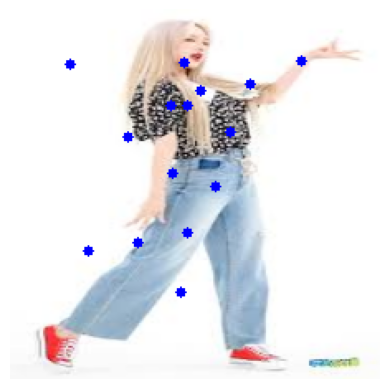

In [ ]:
image = cv2.imread('/content/drive/MyDrive/KakaoTalk_20230603_205127037.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (224, 224))

radius = 3
color = (0, 0, 255)

for idx, joint in enumerate(joint_predictions):
    cv2.circle(image, (int(joint[0]), int(joint[1])), radius, color, -1)

plt.imshow(image)
plt.axis('off')
plt.show()

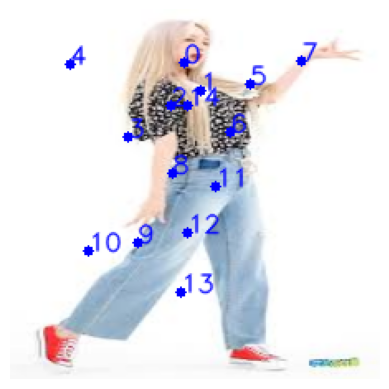

In [ ]:
for idx, joint in enumerate(joint_predictions):
    cv2.circle(image, (int(joint[0]), int(joint[1])), radius, color, -1)
    cv2.putText(image, str(idx), (int(joint[0]), int(joint[1])), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1, cv2.LINE_AA)


plt.imshow(image)
plt.axis('off')
plt.show()

#오픈포즈 변형

48.0 200.0
96.0 32.0
88.0 32.0
96.0 16.0
96.0 32.0
88.0 32.0
96.0 16.0
96.0 32.0
88.0 16.0
96.0 32.0
96.0 136.0
96.0 16.0
88.0 16.0
96.0 136.0
96.0 16.0


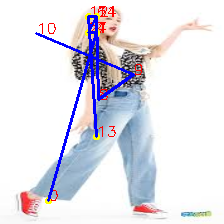

In [ ]:
image = cv2.imread('/content/drive/MyDrive/KakaoTalk_20230603_205127037.jpg')
image = cv2.resize(image, (224, 224))
imageHeight, imageWidth, imageColor = image.shape

inpBlob = cv2.dnn.blobFromImage(image, 1.0 / 255, (imageWidth, imageHeight), (0, 0, 0), swapRB=False, crop=False)
net.setInput(inpBlob)

output=net.forward()

H = output.shape[2]
W = output.shape[3]


points = []
for i in range(0, 15):
    probMap = output[0, i, :, :]

    minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)

    # 원래 이미지에 맞게 점 위치 변경
    x = (imageWidth * point[0]) / W
    y = (imageHeight * point[1]) / H

    print(x,y)
    if i == 8:
        points.append((int(Rhip_predicted_x), int(Rhip_predicted_y)))
    elif i == 10:
        points.append((int(Rwrist_predicted_x), int(Rwrist_predicted_y)))
    elif i == 9:
        points.append((int(Lelbow_predicted_x), int(Lelbow_predicted_y)))
    else:
        points.append((int(x), int(y)))
        cv2.circle(image, (int(x), int(y)), 3, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
        cv2.putText(image, "{}".format(i), (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

# 추가로 숫자를 표시할 좌표에 대해서만
for i, (x, y) in enumerate(points):
    if i == 8 or i == 10 or i == 9:
        cv2.putText(image, "{}".format(i), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)


for pair in POSE_PAIRS:
    partA = pair[0]  # Head
    partA = BODY_PARTS[partA]  # 0
    partB = pair[1]  # Neck
    partB = BODY_PARTS[partB]  # 1

    if points[partA] and points[partB]:
        cv2.line(image, points[partA], points[partB], (255, 0, 0), 2)


cv2_imshow(image)
cv2.waitKey(0)
cv2.destroyAllWindows()